### Project 1 Phase III

In this phase, we develop coding strategies to deal with the situation we developed in phases 1 and 2, which essentially is shooting a clown out of a cannon. This was a difficult task, as there was a lot to consider physically. We had to cut out some of the things we wanted to accomplish in phase 1, but we were able to implement (with some limited success) solve_ivp with root finding to solve the boundary value problem. Before that though, we develop the problem quite a bit with methods for switching between latitude and longitude coordinates to spherical coordinates, as well as some events to deal with the clown going too far in any given direction. We also use simple test cases to gauge the accuracy of our function with respect to the physics being modeled. Only after that do we use root finding to gauge what the appropriate starting conditions should be.

*description*: 
We launch a clown with a mass $m$, from a cannon at a specified location and intital velocity $\vec{v}_{i}$, in an attempt to land him at a target at a different specified location. At some altitude during his descent, the clown will release a parachute, which will increase the drag for the final part of the trip and will stop any non-vertical motion. We assume that the earth is a rotating sphere with an atmosphere and that the clown has certain human limitations, all explained below. By solving a boundary value problem with BLANK input conditions we will specify the trajectory of the clown and whether he will survive the launch. 

*updated assumptions* 
1. The Earth is a rotating sphere:
    - The Earth is assumed to be a sphere of mass $M_{e}$ and radius $R_{e}$, where the force of gravity is a function of height from sea level.
    - We define elevation as the ground height and assume that the lowest elevation is at sea level, $h_{e} = 0 m$, and the highest elevation is Mt. Everest at $h_{e} = 8800m$. 
    - We assume the Earth is rotating and so the Coriolis effect is non-negligible.
    - We will convert from latitude,longitude, and height to spherical coordinates to make the calculations easier.
2. Atmospheric constraints:
    - We assume that the Earth has an atmosphere, which means we will not be neglecting air resistance on the clown.
    - We define altitude as the height above sea level including the atmosphere and assume the lowest altitude is sea level $h_{a} = 0m$, and the highest altitude as $h_{a} = 19000m$. 
    - We will ignore air turbulence, humidity, temperature, wind and other weather effects (velocity of air with respect to the ground everywhere is 0m/s).
    - We assume that the drag on the clown is proportional to the square of his velocity.
3. Assumptions regarding the clown:
    - We assume that the clown has a given mass $m$ that does not change in flight.
    - We assume that the flight profile of the clown is rod-like with some specified cross-sectional area.
    - As the clown is a human we assume he can only handle certain stresses, such as:
        - He cannot survive landing speeds above 10 m/s, so he must be going slower than this when he reaches his destination elevation.  

Remember the main three forces we are considering are gravitation, drag force, and the fictitious force of a rotating body, the Coriolis force. They lead to the following equations of motion for the three component directions as follows:
$$F_r=-\frac{Gm}{r^2}-\frac{1}{2} C_DA|\frac{dr_{v'}}{dt}|^2 (\frac{p_{0}}{RT}*e^{-gmr/RT})-2\frac{m}{r_e}\frac{d\phi_0}{dt}\frac{d\theta_{v'}}{dt}$$
$$F_\phi=-\frac{1}{2} C_DA|\frac{d\phi_{v'}}{dt}|^2 (\frac{p_{0}}{RT}*e^{-gmr/RT})$$
$$F_\theta=-\frac{1}{2} C_DA|\frac{d\theta_{v'}}{dt}|^2 (\frac{p_{0}}{RT}*e^{-gmr/RT}) +2\frac{m}{r_e}\frac{d\phi_0}{dt}\frac{dr_{v'}}{dt}$$

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.optimize as opt
import scipy.integrate as integ
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

We define the spherical plotting environment below. This will help up visualize our results later.

In [51]:
def mpl_sphere(xp,yp,zp,ics,title,vangle=None):
    """plots a set of coordinates about the earth in cartesian space into a trajectory around a wireframe globe
    
    Inputs
    ------
    xp:ndarray
    array of radius positions
    yp:ndarray
    array of theta positions
    zp:ndarray
    array of phi positions
    ics:ndarry
    
    
    """
    rearth=6371000
    r=(ics[:,0]+rearth)/rearth
    phi=ics[:,2]
    theta=ics[:,1]
    xr=r*np.cos(theta)*np.sin(phi)
    yr=r*np.sin(theta)*np.sin(phi)
    zr=r*np.cos(phi)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=xr,ys=yr,zs=zr,label='trajectory',c='b')
    ax.plot(xs=xp,ys=yp,zs=zp,label='trajectory',c='r',zdir='z')
    angle=np.linspace(0,2*np.pi,1000)
    ax.plot(xs=np.cos(angle),ys=np.sin(angle),zs=0*angle,c='k')
    ax.plot(xs=np.cos(angle),zs=np.sin(angle),ys=0*angle,c='k')
    ax.plot(ys=np.cos(angle),zs=np.sin(angle),xs=0*angle,c='k')
    max_val=1
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val,max_val)
    ax.set_zlim(-max_val,max_val)
    ax.set_title(title)
    ax.axis('scaled')
    if vangle !=None:
        ax.view_init(vangle[0],vangle[1])

We then define constants as needed. We list them in order they appear and as they will appear in the code. P0 refers to the atmospheric pressure at height of 0 m. G is the gravitational constant. M is the mass of the earth. Omega is the angular velocity of the earth. r_e is the radius of the earth. R_g is the universal gas constant. R_dry is the gas constant for dry air. T is the temperature of the air. g is the acceleration due to the earth at the surface. mstar is molar mass of air. mc is the mass of the clown. Cd is the drag coefficient of a sphere. We then define B and alpha as ways to combine constants that will appear together.

In [52]:
P0 = 101325 #pa
G = 6.67e-11 #m^3 / kg*s^2
M = 6.e24 #kg
Omega = np.array([0,7.212e-5,0]) #rads/s
r_e = 6.378e6 #m
R_g = 8.314 # gas constant units
R_dry = 287.058 #units work out
T = 293.15 #K
g = 9.81 #m*s^-2
mstar = .02896 #kg/mol
mc = 50 #kg
Cd = 1.2
B = (P0/(R_dry*T))
alpha = (g*mstar)/(R_g*T)

We then define the equations of motion functions which we will input into solve_ivp. The first one is for when we shoot the clown out of the cannon, the second is for when he is parachuting down above his destination.

In [104]:
def clown_ode(t,R):
    '''
    NOTE: this function has the constants used for shooting the clown out of the cannon
    this is the function that we would input into solve_ivp/bvp, it is vectorized, and any quantity in our eom's
    that isnt an arguement of clown_ode is a constant that we will not change that is defined in the program
    INPUTS:
    t - postion in time (s)
    R - vectorized eom's, what copi would represent as y in his ode eqns, defining order to be
    R[0] - position, r, (m)
    R[1] - velo in r direction, m/s
    R[2] - postion, phi, rads (0<phi<2pi)
    R[3] - velo in phi direction, ang freq (rads/s)
    R[4] - postion, theta, rads (0<theta<pi)
    R[5] - velo in theta direction, ang freq, (rads,s)
    *all of this is with respect to the surface of the earth
    Cd - coefficent of drag, wanna allow this to change if we want to make a thiccer clown
    mc - mass of clown (kg)
    A - cross sectional area of clown
    OUTPUTS:
    dRdx - the derivatives for all of the R elements, to be put into solve_ivp
    '''
    P0 = 101325 #pa
    G = 6.67e-11 #m^3 / kg*s^2
    M = 6.e24 #kg
    Omega = np.array([0,7.212e-5*np.sin(R[2]),0]) #rads/s
    r_e = 6.378e6 #m
    R_g = 8.314 # gas constant units
    R_dry = 287.058 #units work out
    T = 293.15 #K
    g = 9.81 #m*s^-2
    mstar = .02896 #kg/mol
    mc = 50 #kg
    Cd = 0.016
    A = 1
    B = (P0/(R_dry*T))
    alpha = (g*mstar)/(R_g*T)
    dRdt = np.zeros_like(R)
    dRdt[0] = R[1]
    dRdt[1] = (1/mc)*(-(G*M*mc)/((r_e + R[0])**2) -np.sign(R[1])*.5*Cd*A*(R[1]*R[1])*(B*np.exp(-alpha*R[0])) - 2*mc*Omega[1]*R[5])
    dRdt[2] = R[3]
    dRdt[3] = (1/mc)*(-np.sign(R[3])*.5*Cd*A*(R[3]*R[3])*(B*np.exp(-alpha*R[0])))
    dRdt[4] = R[5]
    dRdt[5] = (1/mc)*(-np.sign(R[5])*.5*Cd*A*(R[5]*R[5])*(B*np.exp(-alpha*R[0])) + (2/r_e)*mc*Omega[1]*R[1])
    return dRdt

In [54]:
def parachute_ode(t,R):
    '''
    NOTE: this function has values for the clown falling from the targeted height to the ground
    and SHOULD NOT be used to shoot him out of a cannon
    this is the function that we would input into solve_ivp, it is vectorized, and any quantity in our eom's
    that isnt an arguement of clown_ode is a constant that we will not change that is defined in the program
    INPUTS:
    t - postion in time (s)
    R - vectorized eom's, what copi would represent at y in his ode eqns, defining order to be
    R[0] - position, r, (m)
    R[1] - velo in r direction, m/s
    R[2] - postion, phi, rads (0<phi<2pi)
    R[3] - velo in phi direction, ang freq (rads/s)
    R[4] - postion, theta, rads (0<theta<pi)
    R[5] - velo in theta direction, ang freq, (rads,s)
    *all of this is respect to the surface of the earth
    Cd - coefficent of drag, wanna allow this to change if we want make thiccer clown
    mc - mass of clown (kg)
    A - cross sectional area of clown
    OUTPUTS:
    dRdx - the derivatives for all of the R elements, to be put into solve_ivp
    '''
    P0 = 101325 #pa
    G = 6.67e-11 #m^3 / kg*s^2
    M = 6.e24 #kg
    Omega = np.array([0,7.212e-5*np.sin(R[2]),0]) #rads/s
    r_e = 6.378e6 #m
    R_g = 8.314 # gas constant units
    R_dry = 287.058 #units work out
    T = 293.15 #K
    g = 9.81 #m*s^-2
    mstar = .02896 #kg/mol
    mc = 50 #kg
    Cd = 1.75
    A = 5
    B = (P0/(R_dry*T))
    alpha = (g*mstar)/(R_g*T)
    dRdt = np.zeros_like(R)
    dRdt[0] = R[1]
    dRdt[1] = (1/mc)*(-(G*M*mc)/((r_e + R[0])**2) -np.sign(R[1])*.5*Cd*A*(R[1]*R[1])*(B*np.exp(-alpha*R[0])) - 2*mc*Omega[1]*R[5])
    dRdt[2] = R[3]
    dRdt[3] = (1/mc)*(-np.sign(R[3])*.5*Cd*A*(R[3]*R[3])*(B*np.exp(-alpha*R[0])))
    dRdt[4] = R[5]
    dRdt[5] = (1/mc)*(-np.sign(R[5])*.5*Cd*A*(R[5]*R[5])*(B*np.exp(-alpha*R[0])) + (2/r_e)*mc*Omega[1]*R[1])
    return dRdt

We also want to define a function that translates latitude and longitude to spherical coordinates. The spherical coordinates are defined for theta from 0 at the north pole to $\pi$ at the south pole and phi from 0 at the prime meridian to 2$\pi$ also at the prime meridian.

In [55]:
# want a lat/long to spherical coord funct
# theta = polar = lat + 90deg
# phi =azimuthal = long
def make_spherical(lat,lat_dir,long,long_dir):
    '''
    gets spherical coords phi,theta from lat,long
    input:
    lat - latitude (deg)
    lat_dir - float, 1 if N, -1 if S, 0 if 0
    long - longitude (deg)
    long_dir - float, 1 if E, -1 if W, 0 if 0
    output:
    phi - phi coord (rads)
    theta - theta coord (rads)
    '''
    if long_dir>0:
        phi = np.deg2rad(long)
    elif long_dir<0:
        phi = 2*np.pi - np.deg2rad(long)
    else:
        phi = np.deg2rad(long)
    if lat_dir>=0:
        theta = np.pi/2 - np.deg2rad(lat)
    else:
        theta = np.pi/2 + np.deg2rad(lat)
    return np.array([theta,phi])

When we put everything into solve_ivp, we want to define some events where it stops an iteration if it goes too far in some direction. These are very useful when we were doing the shooting method *'by hand'* and wanted to see how close we were getting but not all of them are necessary for our final code.

In [56]:
# all the events in solve_ivp
def FD_r(t,R):
    '''
    SAA but for just the r-component, but a non-terminal event, used to see if our shooting method gets close
    need for r becasue we want him to be ~1000m (+final elavation) at the right location
    '''
    r_f = 1000 #m
    return r_f-R[0]
FD_r.terminal = False
FD_r.direction=0
def FD_phi(t,R):
    '''
    SAA but for the phi-component
    '''
    phi_f = 4.75375677 # rads
    return R[2]-phi_f
FD_phi.terminal=False
FD_phi.direction=0
def FD_theta(t,R):
    '''
    SAA, but for the theta-component
    '''
    theta_f = 0.8398856 # rads
    return R[4]-theta_f
FD_theta.terminal=False
FD_theta.direction=0
def clown_2_ground(t,R):
    '''
    event that stops solve_ivp when the clown lands on the ground,
    shouldnt interfere with 'final_destination'
    inputs: dont actuall input anything
    '''
    return R[0]
clown_2_ground.terminal=True
clown_2_ground.direction=-1

For our testing later, we want to have some locations that we want to hit, so we find the coordinates of these places and change their coordinates from latitude and longitude to spherical. We have also been rounding the elevations down by 100m at a time as an exact height can vary at the location itself. 

In [57]:
# test coords
cle_coord = make_spherical(41.4993,1,81.6944,-1) #ela = 0
chi_coord = make_spherical(41.8781,1,87.6298,-1) #ela = 0
mp_coord = make_spherical(13.1631,-1,72.5450,-1) #ela = 2400
tor_coord = make_spherical(43.6532,1,79.3852,-1) #ela = 0
ny_coord = make_spherical(40.7128,1,74.006,-1) #ela = 0
rus_coord = make_spherical(55.7558,1,37.6173,1) #ela = 0

We also have defined a function that can change all of the initial velocities at once. It is very sensitive to initial conditions. Also beware that the time integrated and the number of points should be similar between this function and clown_bvp. This should be true because we are trying to compare the output of clown_bvp to this function, so they need to be consistent in time for good comparison. It is really easy to find local minima because it uses a multidimensional root finder.

In [58]:
def vary_all_rf(V,r_i,phi_i,theta_i,r_f,phi_f,theta_f):
    '''
    allows rf to vary all inital velos at once yay, note hella senstive to ICs
    also hella surry its annoying af with all the args
    MAKE SURE THE TIME YOU INT ACROSS AND THE AMOUNT OF POINT IS SIMILAR IN THIS FUNC AND CLOWN_BVP!
    inputs:
    V - inital velo guess (array)
    r_i/f - inital/final r coord (float)
    phi_i/f - inital/final phi coord (float)
    theta_i/f - intial/final theta coord (float)
    '''
    R = np.array([r_i,V[0],phi_i,V[1],theta_i,V[2]])
    tf = 300.
    tsp = np.linspace(0,tf,1000)
    guess = integ.solve_ivp(clown_ode,(0,tf),R,t_eval=tsp,vectorized=True,events=(FD_r))
    return [(guess.y[0,-1]-r_f),(guess.y[2,-1]-phi_f),(guess.y[4,-1]-theta_f)]

# Test Cases

To test our physics, we need to institute a few intuitive test cases. Since we know what should happen in a few of the test cases, this will guide our knowledge of whether our code is working. 

## Drop From North Pole

When we drop the clown from above the north pole (where our initial velocities are zero in all three of the coordinates, and we just evolve in time and see what happens), we should expect that the major forces at play are gravity and drag force. We should not expect the coriolis force to play a role in a drop from above the north pole. This is true because the coriolis force is a fictitious force that occurs as a result of the earth rotating at a different speed under an object. However, since we are dropping from above the north pole, there should be no relative angular motion between the surface and the dropping clown. This means we should expect to see the clown dropping straight down, which is what we see in the following test. We begin by creating the drop event and running it through integ.solve_ivp

In [59]:
pole_dropR = np.array([10000,0,0,0,0,0])
tf_pole_drop = 300
tsp_pole_drop = np.linspace(0,tf_pole_drop,400)
pole_drop_test = integ.solve_ivp(clown_ode,(0,tf_pole_drop),pole_dropR,t_eval=tsp_pole_drop,vectorized=True,events=(clown_2_ground))

Next we display the results of integ.solve_ivp, noting that there is motion in the r direction, but not in the $\phi$ or $\theta$ direction. We also see that a termination event occurred, which happens as a result of the clown hitting the ground. 

Next we plot the r position and velocity against time

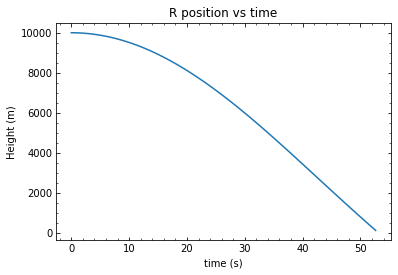

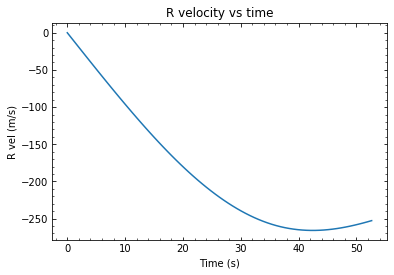

In [60]:
fig2 = plt.figure();
ax2 = fig2.add_subplot(111);
ax2.plot(pole_drop_test.t,pole_drop_test.y[0]);
ax2.set_xlabel("time (s)");
ax2.set_ylabel("Height (m)");
ax2.set_title("R position vs time");

fig = plt.figure();
ax = fig.add_subplot(111);

ax.plot(pole_drop_test.t,pole_drop_test.y[1]);
ax.set_xlabel("Time (s)");
ax.set_ylabel("R vel (m/s)");
ax.set_title("R velocity vs time");

This is exactly what we would expect in the radial direction. By looking at the R velocity over time we can see the velocity increase as gravity accelerates the projectile downward until it reaches terminal velocity. then as the projectile moves farther down air density and therefore drag increases decreasing the terminal velocity by a moderate amount until the projectile reaches the ground.

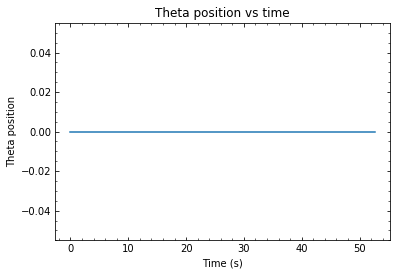

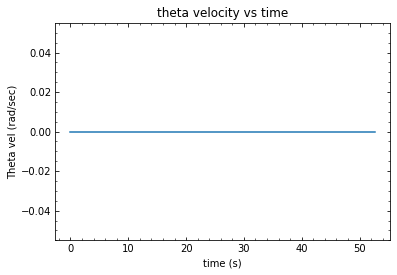

In [61]:
fig = plt.figure();
ax = fig.add_subplot(111);

ax.plot(pole_drop_test.t,pole_drop_test.y[4]);
ax.set_xlabel("Time (s)");
ax.set_ylabel("Theta position");
ax.set_title("Theta position vs time");

fig2 = plt.figure();
ax2 = fig2.add_subplot(111);
ax2.plot(pole_drop_test.t,pole_drop_test.y[5]);
ax2.set_xlabel("time (s)");
ax2.set_ylabel("Theta vel (rad/sec)");
ax2.set_title("theta velocity vs time");

When plotting the theta position and velocity against time. We also see that theta and theta velocity do not change over time, which is exactly what we should expect if no coriollis force is exerted

## Drop from Cleveland

Next we try a test case where we drop from above Cleveland. As before, we should expect to see the clown get to terminal velocity, but this time he will have some additional velocity in the theta direction as a result of the coriolis force coming into play. More explicitly, since the earth is rotating under the clown, we should see some fictitious force and there should be some theta velocity. We begin again by initiating the drop parameters, this time with different starting coordinates.

In [62]:
#test case for dropping it from a height to show coriolis force works
dropR = np.array([10000,0,cle_coord[1],0,cle_coord[0],0])
tf_drop = 300
tsp_drop = np.linspace(0,tf_drop,100)
drop_test = integ.solve_ivp(clown_ode,(0,tf_drop),dropR,t_eval=tsp_drop,vectorized=True,events=(clown_2_ground))

We see that again a termination case occurs, which once again is a result of the clown hitting the ground. We also see this time that there is some small theta velocity, on the order of the rotational velocity of the earth. We again examine the plots of r position and velocity and theta position and velocity all against time to get a better picture of what is happening. 


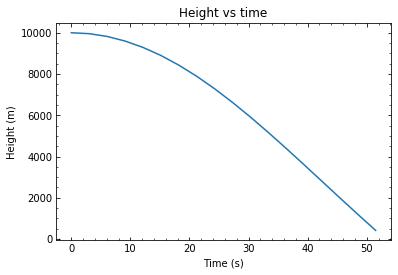

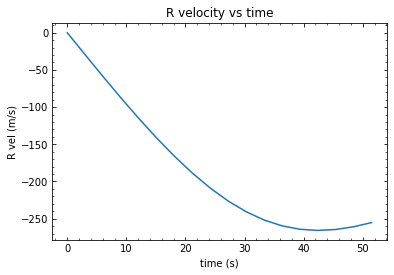

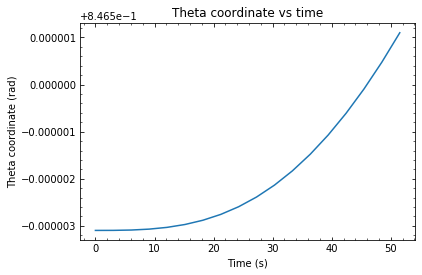

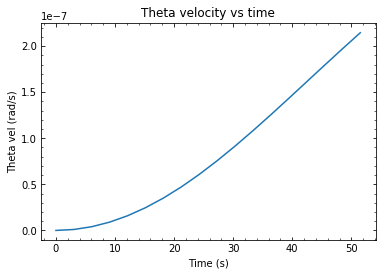

In [63]:
fig = plt.figure();
ax = fig.add_subplot(111);

ax.plot(drop_test.t,drop_test.y[0]);
ax.set_xlabel("Time (s)");
ax.set_ylabel("Height (m)");
ax.set_title("Height vs time");

fig2 = plt.figure();
ax2 = fig2.add_subplot(111);
ax2.plot(drop_test.t,drop_test.y[1]);
ax2.set_xlabel("time (s)");
ax2.set_ylabel("R vel (m/s)");
ax2.set_title("R velocity vs time");

fig = plt.figure();
ax = fig.add_subplot(111);

ax.plot(drop_test.t,drop_test.y[4]);
ax.set_xlabel("Time (s)");
ax.set_ylabel("Theta coordinate (rad)");
ax.set_title("Theta coordinate vs time");

fig2 = plt.figure();
ax2 = fig2.add_subplot(111);

ax2.plot(drop_test.t,drop_test.y[5]);
ax2.set_xlabel("Time (s)");
ax2.set_ylabel("Theta vel (rad/s)");
ax2.set_title("Theta velocity vs time");

We see this time that there is velocity in the theta direction as a result of the coriolis force while the radial velocity stays approximately the same, so this shows our equations are doing what they should.

# Testing our Shot

## Contending with clown_bvp

In order to properly implement the shooting method we built clown_bvp that solves an ivp and then root finds with the result to solve the boundary value problem. 

In [64]:
def clown_bvp(a_coord,b_coord,vr_guess,method,full_out=False):
    '''
    generalized clown bvp solver
    gets spherical coords phi,theta from lat,long
    this function takes in the launch paramters and then is able to tell you
    the clowns trajectory, and his error from his intended destination, 
    input:
    a_coord - the coord and elavation of the clowns starting point, array with 5 elements, 0-3 are input into 'make_spherical', 4 is elavation (array)
    b_coord - the coord and elavation of the clowns ending point, array with 5 elements, 0-3 are input into 'make_spherical', 4 is elavation (array)
    below is doc for 'make_spherical'
        lat - latitude (deg)
        lat_dir - float, 1 if N, -1 if S, 0 if 0
        long - longitude (deg)
        long_dir - float, 1 if E, -1 if W, 0 if 0
        output:
        theta - theta coord (rads)
        phi - phi coord (rads)
    vr_guess - intial guesses for the r velo (float)
    method - rf method passsed into 'opt.root', (string), current approved methods are: 'hybr','broyden1','lm'
    outputs:
    
    '''
#     put this event in so we dont have to edit the one outside the function
    def FD_r_bvp(t,R):
        'event to see when r-comp gets to final r pos'
        ela = 2800 #equal to b_coord[4] have to change every time
        r_f = 1000.+ela
        return r_f-R[0]
#     1 means neg to pos, -1 means pos to neg
    FD_r_bvp.direction=1 # prob wanna use 1 but might have to swithc
    FD_r_bvp.terminal=False
#     convert input coordinates to spherical
    i_coord=make_spherical(a_coord[0],a_coord[1],a_coord[2],a_coord[3])
    f_coord=make_spherical(b_coord[0],b_coord[1],b_coord[2],b_coord[3])
    guess=np.zeros_like(i_coord)
#     guess is the difference between the theta and phi values so that the trajectory from point A
#     will point directly towards point B
    guess[0]=f_coord[0]-i_coord[0]
    guess[1]=f_coord[1]-i_coord[1]
    tf5 = 300
    R5=np.array([a_coord[4],vr_guess,i_coord[1],guess[1]/tf5,i_coord[0],guess[0]/tf5])
    tsp5 = np.linspace(0,tf5,20000)
#     test5 solves the ivp over the for the initial guess
    test5 = integ.solve_ivp(clown_ode,(0,tf5),R5,t_eval=tsp5,vectorized=True,events=clown_2_ground)
    ics=np.array([[a_coord[4],i_coord[1],i_coord[0]],[b_coord[4],f_coord[1],f_coord[0]]])
    r=(test5.y[0]+r_e)/r_e
    theta=test5.y[2]
    phi=test5.y[4]
    xs=r*np.cos(theta)*np.sin(phi)
    ys=r*np.sin(theta)*np.sin(phi)
    zs=r*np.cos(phi)
#     this is the trajectory of our inital guess
#     we have these if we want a different view but for the most part it doesnt need it
    mpl_sphere(xs,ys,zs,ics,'Initial Guess Plot',[30,30])
#     inital guesses for root to use
    V = np.array([vr_guess,guess[1]/tf5,guess[0]/tf5])
    #root attempts to find the roots of our equations of motion given our final destination and our initial guess
    soln = opt.root(vary_all_rf,V,args=(a_coord[4],i_coord[1],i_coord[0],b_coord[4],f_coord[1],f_coord[0]),method=method)
    #the solution is then put back into our ivp now with the proper initial conditions
    R5_final = np.array([0,soln.x[0],i_coord[1],soln.x[1],i_coord[0],soln.x[2]])
    FD_r_bvp.terminal=True #change to true cuz we want 'solve_ivp' to actually stop at the right point
    test5_final = integ.solve_ivp(clown_ode,(0,tf5),R5_final,t_eval=tsp5,vectorized=True,events=(FD_r_bvp))
#     The results are then plotted
    rf=(test5_final.y[0]+r_e)/r_e
    thetaf=test5_final.y[2]
    phif=test5_final.y[4]
    xsf=rf*np.cos(thetaf)*np.sin(phif)
    ysf=rf*np.sin(thetaf)*np.sin(phif)
    zsf=rf*np.cos(phif)
#     same as above, we have more viewpoints but really dont need it
    mpl_sphere(xsf,ysf,zsf,ics,'Final Plot',[30,30])
    if(full_out==True):
        mpl_sphere(xsf,ysf,zsf,ics,'x-z plane',[0,0])
        mpl_sphere(xsf,ysf,zsf,ics,'y-z plane',[0,270])
        mpl_sphere(xsf,ysf,zsf,ics,'x-y plane',[90,0])
#     now for final descent in the parachute to the ground
    R_para = np.array([test5_final.y[0,-1],test5_final.y[1,-1],test5_final.y[2,-1],0,test5_final.y[4,-1],0])
    fall_time = 1000
    ft_vec = np.linspace(0,fall_time,1000)
    para_ivp = integ.solve_ivp(parachute_ode,(0,fall_time),R_para,t_eval=ft_vec,vectorized=True,events=clown_2_ground)
#     want error in each solved final location to actual final location
    dest = np.array([1+b_coord[4],f_coord[1],f_coord[0]])
    gnd = np.array([((para_ivp.y[0,-1]+r_e)/r_e),para_ivp.y[2,-1]%(2*np.pi),para_ivp.y[4,-1]%np.pi])
    final_error = gnd-dest
#     extra output we can use that help us narrow down parameters to use
    print('error is','r=',final_error[0]*r_e,'phi=',final_error[1],'theta=',final_error[2])
#     ^ is the final error of how far the clown ended up versus were we wanted to get him
    print('where clown is supposed to be',b_coord[4],f_coord[1],f_coord[0])
    print('where clown actually be',para_ivp.y[0,-1],para_ivp.y[2,-1],para_ivp.y[4,-1])
#     ^ tells us really where the clown actually ended up 
#     Describing the outputs of the rootfinding function
    print('the outputted solutions of the rootfinding function are:',soln.x)
    print('did these values converge on a minima?',soln.success)
    print('The rootfinder stopped because:',soln.message)
    print('it took',soln.nfev,' evaluations to get the values above')
    print('which when input into "rf_vary_all" gets an array',soln.fun,' this close to zero')
#     ^ the outputs of our rootfinding, which is useful for diagnostics, and is less cluttered than outputing the actual full output
#     did the clown survive?
    land_condit = para_ivp.y[1,-1]<10 #did the parachute slow him down to >10m/s
    h_condit = np.any(test5_final.y[0]>19000) #did the clown go to high?
    alive = not(land_condit or h_condit)
    print('did he go above 19 km?', h_condit, 'did he land faster than 10 m/s?',land_condit)
    print('did the clown survive being launched out of the cannon???', alive)
    return 

### Testing the BVP

We now would like to try several test runs of our function. In which we shoot the clown, at the end of this you are welcome to input any coordinates you would like and see how close he gets!

First test: Cleveland, OH to Chicago, IL

error is r= 4.98166499964281 phi= 0.0028748345144737897 theta= 0.00018682010223258771
where clown is supposed to be 0.0 4.753756774315459 0.8398855973154592
where clown actually be 4.981665000340859 4.756631608829933 0.8400724174176918
the outputted solutions of the rootfinding function are: [ 6.78353063e+03 -3.45307636e-04 -2.05265407e-05]
did these values converge on a minima? True
The rootfinder stopped because: The solution converged.
it took 27  evaluations to get the values above
which when input into "rf_vary_all" gets an array [9.41917096e-06 7.23624627e-09 6.17381958e-08]  this close to zero
did he go above 19 km? True did he land faster than 10 m/s? True
did the clown survive being launched out of the cannon??? False


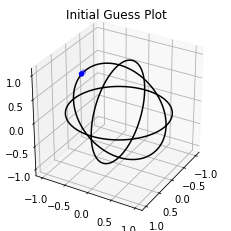

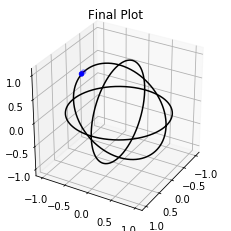

In [65]:
#1st test cle->chi
a1 = np.array([41.4993,1,81.6944,-1,0])
b1 = np.array([41.8781,1,87.6298,-1,0])
vr1 = 700
meth1 = 'hybr'
# vr1 = np.linspace(700,1200.,10)
clown_bvp(a1,b1,vr1,meth1)

It is very hard to see how the function does from the outputted graphs but if you read the text the function spits out, you can see the root finder doesnt get particularly close to zero. However, he still ends up pretty close to his destination. (if you do the math he ends up within a 100 mile radius of chicago, which isn't too bad) This is a key example of the root finding being real sensitve. Just like our example below.

2nd test: Machu Picchu, Peru to Toronto, Canada

error is r= 2.108591783463787 phi= 0.036730341833870916 theta= 0.30523508826333745
where clown is supposed to be 0.0 4.897652189825384 0.8089042577633079
where clown actually be 2.108591782791901 4.934382531659255 1.1141393460266453
the outputted solutions of the rootfinding function are: [ 4.53066231e+03 -3.97946807e-04 -3.30403553e-03]
did these values converge on a minima? True
The rootfinder stopped because: The relative error between two consecutive iterates is at most 0.000000
it took 30  evaluations to get the values above
which when input into "rf_vary_all" gets an array [ 7.80664777e-09  8.88178420e-16 -5.55111512e-16]  this close to zero
did he go above 19 km? True did he land faster than 10 m/s? True
did the clown survive being launched out of the cannon??? False


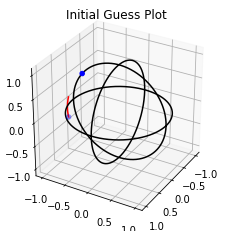

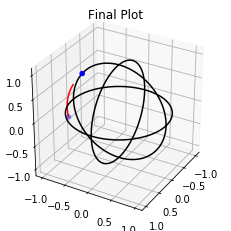

In [66]:
# 2nd test, mp->tor
a2 = np.array([13.1631,-1,72.5450,-1,2400])
b2 = np.array([43.6532,1,79.3852,-1,0])
vr2 = 1200
clown_bvp(a2,b2,vr2,'lm')

Here you can actually see the improvement on the plot. However the clown misses his destination by a lot on this one. You can really see the effect of local minima because the root finding keeps settling on these values even though it is no where near the final destination.

Test 3: New York, NY to Moscow, Russia

error is r= 9.12302169430923 phi= 0.1202988321994174 theta= 0.007290350281577207
where clown is supposed to be 0.0 0.6565457407104629 0.5976740397114422
where clown actually be 9.123021694290461 0.7768445729098803 0.6049643899930194
the outputted solutions of the rootfinding function are: [ 6.78377616e+03 -1.44501208e-02 -8.73022256e-04]
did these values converge on a minima? True
The rootfinder stopped because: The relative error between two consecutive iterates is at most 0.000000
it took 38  evaluations to get the values above
which when input into "rf_vary_all" gets an array [ 1.70894054e-09 -4.44089210e-16 -1.11022302e-16]  this close to zero
did he go above 19 km? True did he land faster than 10 m/s? True
did the clown survive being launched out of the cannon??? False


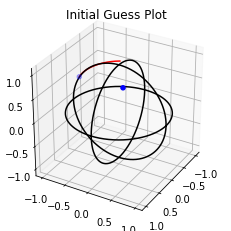

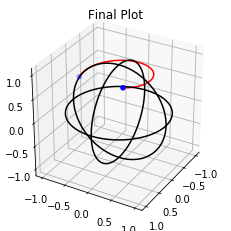

In [67]:
# test 3 NY->red square
a3 = np.array([40.7128,1,74.006,-1,0])
b3 = np.array([55.7558,1,37.6173,1,0])
vr3 = 1000
clown_bvp(a3,b3,vr3,'lm')

You can see the improvement in this test case as the clown actually makes it close to Moscow! Like the previous examples he keeps dying because hes still going to fast when he lands, which means we probably should have made it a higher, or his tolerance speed a little higher, because he is only going about 15m/s which deffinately wouldnt kill the clown, especially if he can survive being shot out of a cannon at thousands of meters per second.

Test 4: Perth, Australia to Fujikawaguchiko, Japan
(A small town at the base of Mt. Fuji)

error is r= -17858399990.826992 phi= -0.0024775643366483635 theta= 0.00729046507660458
where clown is supposed to be 2800.0 2.421735094263236 0.9512515662267134
where clown actually be 9.173006717523561 2.4192575299265875 0.9585420313033179
the outputted solutions of the rootfinding function are: [ 6.94958888e+03  1.33196082e-03 -3.92545149e-03]
did these values converge on a minima? True
The rootfinder stopped because: The relative error between two consecutive iterates is at most 0.000000
it took 34  evaluations to get the values above
which when input into "rf_vary_all" gets an array [-1.49793777e-09  4.44089210e-16  0.00000000e+00]  this close to zero
did he go above 19 km? True did he land faster than 10 m/s? True
did the clown survive being launched out of the cannon??? False


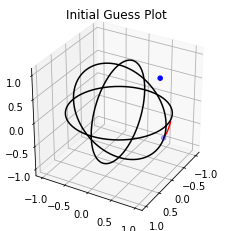

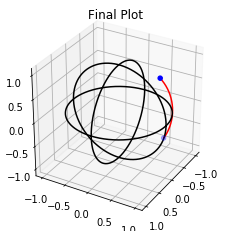

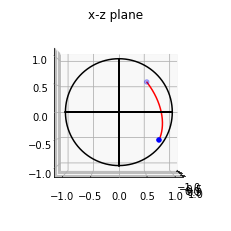

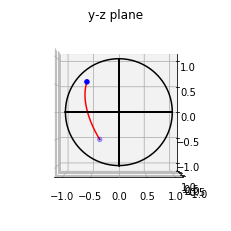

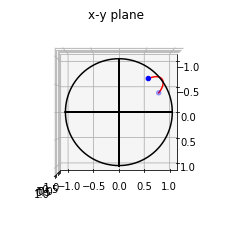

In [68]:
a4 = np.array([31.9505,-1,115.8605,1,0])
b4 = np.array([35.4973,1,138.7552,1,2800])
vr4 = 801
clown_bvp(a4,b4,vr4,'lm',full_out=True)

If you want to see how senstive this root finder is, change 'vr4' from 800 to 900. What is crazy is that during inital testing with the rootfinding before it was implemented into a full function, we discovered how sensitive it was to the inital guess of $V_{r}$, that behavior did not persist with the variance of the other two components to a degree even close to $V_{r}$

# Launching Objects on your Own

In [146]:
#all angles and angular velocities are in terms of radians
launch_height=100000 #radial height over the surface of the earth
thetapos=cle_coord[1] #latitude
phipos=0 #longitude
#launch velocities
radialv=1000 
thetav=0
phiv=.01

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


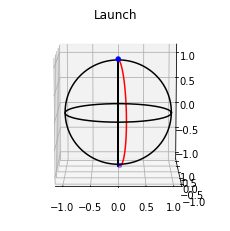

In [147]:
dropR = np.array([launch_height,radialv,thetapos,thetav,phipos,phiv])
tf_drop = 300
tsp_drop = np.linspace(0,tf_drop,100)
drop_test = integ.solve_ivp(clown_ode,(0,tf_drop),dropR,t_eval=tsp_drop,vectorized=True,events=(clown_2_ground))
rf=(drop_test.y[0]+r_e)/r_e
thetaf=drop_test.y[2]
phif=drop_test.y[4]
xsf=rf*np.cos(thetaf)*np.sin(phif)
ysf=rf*np.sin(thetaf)*np.sin(phif)
zsf=rf*np.cos(phif)
ics = np.array([[drop_test.y[0,0],drop_test.y[2,0],drop_test.y[4,0]],[drop_test.y[0,-1],drop_test.y[2,-1],drop_test.y[4,-1]]])
mpl_sphere(xsf,ysf,zsf,ics,'Launch',[10,270])